In [1]:
import json
import networkx as nx
from helpers import handle_empty
import numpy as np
from tqdm import tqdm, trange
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch.utils.data import DataLoader

/home/vunz/Projects/Diploma/jup/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
data = []
counter = 0
with open("../data/dblp_papers_v11.txt", "r") as f:
    for line in f:
        data.append(json.loads(line))
        counter += 1
        if counter == 175000:
            break

In [14]:
def indexed_to_abstract(abstract):
    return " ".join(list(abstract["InvertedIndex"].keys()))

def authors_to_str(authors):
    res = []
    for a in authors:
        res.append(a["name"])
    return ",".join(res)

def fos_to_keys(fos):
    res = []
    for fo in fos:
        res.append(fo["name"])
    return ", ".join(res)

In [15]:
def process_article(article: dict) -> tuple:
    """
    to return: tuple(id, features)
    features should include if possible:
    title, authors, venue, year, abstract, references
    """
    id = article["id"] if "id" in article.keys() else None
    title = article["title"] if "title" in article.keys() else None
    authors = authors_to_str(article["authors"]) if "authors" in article.keys() else None
    venue = article["venue"]["raw"] if "venue" in article.keys() else None
    year = article["year"] if "year" in article.keys() else None
    abstract = indexed_to_abstract(article["indexed_abstract"]) if "indexed_abstract" in article.keys() else None
    references = article["references"] if "references" in article.keys() else None
    keywords = fos_to_keys(article["fos"]) if "fos" in article.keys() else None
    return (id, {
        "title": title,
        "authors": authors,
        "venue": venue,
        "year": year,
        "abstract": abstract,
        "references": references,
        "keywords": keywords
    })

In [16]:
graph = nx.Graph()

In [17]:
data_dict = dict()
for art in data:
    id, features = process_article(art)
    data_dict[id] = features


In [18]:
graph.add_nodes_from(data_dict.keys())

In [19]:
for id in data_dict:
    refs = data_dict[id]["references"]
    if refs is None:
        continue
    for ref in refs:
        if ref in graph.nodes:
            graph.add_edge(id, ref)

In [20]:
def quick_info(g):
    print(f"Number of resulting nodes: {len(g.nodes)}")
    print(f"Number of edges in resulting graph: {len(g.edges)}")
    if nx.is_connected(g):
        print("The graph is connected!")
    else:
        print(f"The graph is not connected, having {nx.number_connected_components(g)} connected components")

In [21]:
quick_info(graph)

Number of resulting nodes: 175000
Number of edges in resulting graph: 61051
The graph is not connected, having 126695 connected components


In [22]:
largest_cc = max(nx.connected_components(graph), key=len)
subgraph = nx.subgraph(graph, largest_cc)

In [23]:
quick_info(subgraph)

Number of resulting nodes: 34887
Number of edges in resulting graph: 47237
The graph is connected!


In [24]:
sub = nx.Graph(subgraph)

In [25]:
sub_graph_labels = dict()
for node in sub.nodes:
    sub_graph_labels[node] = data_dict[node]

In [26]:
titles = [handle_empty(sub_graph_labels[obj]["title"]) for obj in sub_graph_labels]
authors = [handle_empty(sub_graph_labels[obj]["authors"]) for obj in sub_graph_labels]
venues = [handle_empty(sub_graph_labels[obj]["venue"]) for obj in sub_graph_labels]
years = [sub_graph_labels[obj]["year"] if sub_graph_labels[obj]["year"] else 0 for obj in sub_graph_labels]
abstracts = [handle_empty(sub_graph_labels[obj]["abstract"]) for obj in sub_graph_labels]
keywords = [handle_empty(sub_graph_labels[obj]["keywords"]) for obj in sub_graph_labels]


In [27]:
print(np.mean(np.array(years)))
print(np.array(years).max())
print(np.array(years).min())

2005.194542379683
2018
1959


In [28]:
tfidf_vectorizer = TfidfVectorizer(max_features=300)
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
scaler = MinMaxScaler()

In [29]:
title_embeddings = sentence_model.encode(titles)
author_embeddings = sentence_model.encode(authors)
venue_embeddings = sentence_model.encode(venues)
abstract_embeddings = sentence_model.encode(abstracts)
keyword_embeddings = tfidf_vectorizer.fit_transform(keywords).toarray()
years_normalized = scaler.fit_transform(np.array(years).reshape(-1, 1))

encoded_data = np.hstack([
    title_embeddings,
    author_embeddings,
    venue_embeddings,
    years_normalized,
    abstract_embeddings,
    keyword_embeddings
])
print(encoded_data.shape)

(34887, 1837)


In [30]:
encoded_data_no_year = np.hstack([
    title_embeddings,
    author_embeddings,
    venue_embeddings,
    abstract_embeddings,
    keyword_embeddings
])

In [31]:
node_list = list(sub.nodes())
node_mapping = {node: idx for idx, node in enumerate(node_list)}
graph = nx.relabel_nodes(sub, node_mapping)

In [32]:
years_dict = dict(enumerate(years))
nx.set_node_attributes(graph, years_dict, name="year")

In [33]:
from torch_geometric.utils import from_networkx

pyg_data = from_networkx(graph)

In [34]:
def create_dataset(g: nx.Graph, graph, node_labels, target_function):
    x = torch.tensor(node_labels, dtype=torch.float)
    edge_index = graph.edge_index
    y = torch.tensor(list(target_function(g).values()), dtype=torch.float)
    return Data(x=x, edge_index=edge_index, y=y)

In [35]:
device = torch.device("cpu")

In [36]:
dataset_pr = create_dataset(graph, pyg_data, encoded_data, nx.pagerank).to(device)
dataset_harmonic = create_dataset(graph, pyg_data, encoded_data, nx.harmonic_centrality).to(device)

In [37]:
print((np.array(years)==2018).sum())
print((np.array(years)==2017).sum())
print((np.array(years)==2016).sum())

16
54
340


In [38]:
test_nodes = [n for n, attr in graph.nodes(data=True) if attr.get('year') == 2016]
train_nodes = [n for n, attr in graph.nodes(data=True) if attr.get('year') < 2016]

In [39]:
train_mask = (torch.zeros(len(graph.nodes), dtype=torch.bool).to(device))
train_mask[train_nodes] = True
test_mask = (torch.zeros(len(graph.nodes), dtype=torch.bool).to(device))
test_mask[test_nodes] = True

In [40]:
class GATRegression(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GATRegression, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)
    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x

In [41]:
model = GATRegression(in_channels=encoded_data.shape[1], hidden_channels=64, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

In [42]:
def train(epochs, data, model, optimizer, loss_fn, train_mask, test_mask):
    for epoch in trange(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index).squeeze()
        loss = loss_fn(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0 or epoch == epochs - 1:
            print(f"Loss: {loss.item()}")
    model.eval()
    with torch.no_grad():
        predictions = model(data.x, data.edge_index).squeeze()
        test_loss = loss_fn(predictions[test_mask], data.y[test_mask])
        print(f'Test Loss: MSE = {test_loss.item()}')

In [43]:
train(500, dataset_pr, model, optimizer, loss_fn, train_mask, test_mask)

  0%|          | 1/500 [00:01<08:40,  1.04s/it]

Loss: 0.004026798531413078


 10%|█         | 51/500 [00:47<09:43,  1.30s/it]

Loss: 0.0009193026344291866


 20%|██        | 101/500 [01:59<10:09,  1.53s/it]

Loss: 0.0004340907034929842


 30%|███       | 151/500 [03:17<09:08,  1.57s/it]

Loss: 0.0003024851612281054


 40%|████      | 201/500 [04:37<07:54,  1.59s/it]

Loss: 0.00021548118093051016


 50%|█████     | 251/500 [05:56<06:34,  1.58s/it]

Loss: 0.0001692720252322033


 60%|██████    | 301/500 [07:15<05:16,  1.59s/it]

Loss: 0.000130471758893691


 70%|███████   | 351/500 [08:35<03:57,  1.59s/it]

Loss: 0.00010821050818776712


 80%|████████  | 401/500 [09:54<02:36,  1.58s/it]

Loss: 9.130486432695761e-05


 90%|█████████ | 451/500 [11:14<01:17,  1.59s/it]

Loss: 7.598357478855178e-05


100%|██████████| 500/500 [12:32<00:00,  1.50s/it]

Loss: 6.538217712659389e-05


Test Loss: MSE = 1.4516814189846627e-05


In [44]:
torch.std(dataset_pr.y)

tensor(4.2764e-05)

In [193]:
model = GATRegression(in_channels=encoded_data.shape[1], hidden_channels=64, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

In [ ]:
train(500, dataset_harmonic, model, optimizer, loss_fn, train_mask, test_mask)

  0%|          | 2/1000 [00:00<02:12,  7.53it/s]

Loss: 98588.4766


  5%|▌         | 52/1000 [00:04<01:44,  9.10it/s]

Loss: 69461.6953


 10%|█         | 102/1000 [00:09<01:09, 12.92it/s]

Loss: 26365.0293


 15%|█▌        | 152/1000 [00:13<01:05, 13.01it/s]

Loss: 11619.8545


 20%|██        | 202/1000 [00:17<01:01, 12.90it/s]

Loss: 11066.7100


 25%|██▌       | 252/1000 [00:21<00:58, 12.80it/s]

Loss: 9386.3066


 30%|███       | 302/1000 [00:25<00:55, 12.50it/s]

Loss: 7898.2285


 35%|███▌      | 352/1000 [00:29<00:49, 13.10it/s]

Loss: 7472.0088


 40%|████      | 402/1000 [00:33<00:48, 12.34it/s]

Loss: 7085.8862


 45%|████▌     | 452/1000 [00:37<00:42, 13.03it/s]

Loss: 6777.2598


 50%|█████     | 502/1000 [00:41<00:38, 13.09it/s]

Loss: 6197.8906


 55%|█████▌    | 552/1000 [00:45<00:34, 12.93it/s]

Loss: 6324.5879


 60%|██████    | 602/1000 [00:49<00:30, 13.10it/s]

Loss: 5853.5840


 65%|██████▌   | 652/1000 [00:53<00:26, 13.03it/s]

Loss: 6051.9507


 70%|███████   | 702/1000 [00:57<00:22, 13.23it/s]

Loss: 5976.8647


 75%|███████▌  | 752/1000 [01:01<00:22, 11.18it/s]

Loss: 5661.7163


 80%|████████  | 802/1000 [01:04<00:15, 13.15it/s]

Loss: 5794.0249


 85%|████████▌ | 853/1000 [01:09<00:13, 11.24it/s]

Loss: 6249.3765


 90%|█████████ | 903/1000 [01:13<00:07, 13.19it/s]

Loss: 5306.6802


 95%|█████████▌| 953/1000 [01:17<00:03, 13.03it/s]

Loss: 5883.4907


100%|██████████| 1000/1000 [01:20<00:00, 12.35it/s]

Loss: 5885.3931
Test Loss: MSE = 6086.845703125


In [195]:
torch.std(dataset_harmonic.y)

tensor(66.5860)

In [45]:
class GATEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, heads):
        super().__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.conv2 = GATConv(hidden_dim*heads, hidden_dim, heads=1)
        
    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [46]:
class TemporalModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [47]:
class GraphTemporalPipeline(nn.Module):
    def __init__(self, gat_encoder, temporal_model):
        super().__init__()
        self.gat_encoder = gat_encoder
        self.temporal_model = temporal_model
        
    def forward(self, graphs):
        # Encode each graph
        embeddings = []
        for graph in graphs:
            emb = self.gat_encoder(graph.x, graph.edge_index)
            emb = emb.mean(dim=0)
            embeddings.append(emb)
        
        # Stack embeddings over time [num_years, num_nodes, embedding_dim]
        temporal_input = torch.stack(embeddings, dim=0).unsqueeze(0)
        
        # Predict centrality measures
        return self.temporal_model(temporal_input)

In [48]:
num_nodes = encoded_data_no_year.shape[0]
num_features = encoded_data_no_year.shape[1]
hidden_dim = 64
num_heads = 2
years_range = list(range(2000, 2015))

In [49]:
def load_graph(year, graph, encodings, target_func):
    filtered_nodes = [n for n, attr in graph.nodes(data=True) if 0 < attr.get('year') <= year]
    filtered_edges = [(u, v) for u,v in graph.edges if u in filtered_nodes and v in filtered_nodes]
    subgraph = nx.Graph()
    subgraph.add_nodes_from(graph.nodes)
    subgraph.add_edges_from(filtered_edges)
    # subgraph = graph.subgraph(filtered_nodes)
    pyg_data = from_networkx(subgraph)
    x = torch.tensor(np.array(encodings), dtype=torch.float)
    edge_indices = pyg_data.edge_index
    y = torch.tensor(list(target_func(subgraph).values()), dtype=torch.float)
    return Data(x=x, edge_index=edge_indices, y=y)

In [50]:
def train_lstm(epochs, seqs, model, optimizer, criterion):
    for epoch in trange(epochs):
        for sequence, target in seqs:
            optimizer.zero_grad()
            preds = model(sequence)
            loss = criterion(preds, target.y.unsqueeze(0))
            loss.backward()
            optimizer.step()
        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f"Loss: {loss.item():.4f}")

In [51]:
graphs = [load_graph(year, graph, encoded_data_no_year, nx.pagerank) for year in years_range]
sequences = []
for i in range(len(graphs) - 1):
    sequence = graphs[:i+1]
    target = graphs[i+1]
    sequences.append((sequence, target))

In [ ]:
graphs_harmonic = [load_graph(year, graph, encoded_data_no_year, nx.harmonic_centrality) for year in years_range]
sequences_harmonic = []
for i in range(len(graphs_harmonic) - 1):
    sequence = graphs_harmonic[:i+1]
    target = graphs_harmonic[i+1]
    sequences_harmonic.append((sequence, target))

TypeError: '<' not supported between instances of 'int' and 'NoneType'

In [52]:
gat = GATEncoder(num_features, hidden_dim, num_heads)
temporal = TemporalModel(hidden_dim, hidden_dim, num_nodes)
pipeline = GraphTemporalPipeline(gat, temporal)
optimizer = torch.optim.Adam(pipeline.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [53]:
train_lstm(50, sequences, pipeline, optimizer, criterion)

  2%|▏         | 1/50 [01:22<1:07:01, 82.07s/it]

Loss: 0.0002


 12%|█▏        | 6/50 [06:38<45:12, 61.64s/it]  

Loss: 0.0000


 22%|██▏       | 11/50 [11:17<36:39, 56.40s/it]

Loss: 0.0000


 32%|███▏      | 16/50 [15:48<30:54, 54.53s/it]

Loss: 0.0000


 42%|████▏     | 21/50 [20:14<25:48, 53.40s/it]

Loss: 0.0000


 52%|█████▏    | 26/50 [24:43<21:39, 54.16s/it]

Loss: 0.0000


 62%|██████▏   | 31/50 [29:16<17:10, 54.26s/it]

Loss: 0.0000


 72%|███████▏  | 36/50 [33:34<12:08, 52.01s/it]

Loss: 0.0000


 82%|████████▏ | 41/50 [37:50<07:40, 51.20s/it]

Loss: 0.0000


 92%|█████████▏| 46/50 [42:03<03:23, 50.75s/it]

Loss: 0.0000


100%|██████████| 50/50 [45:25<00:00, 54.51s/it]

Loss: 0.0000


In [54]:
graphs.append(load_graph(2016, graph, encoded_data_no_year, nx.pagerank))
sequences.append([graphs[:-1], graphs[-1]])
pipeline.eval()
with torch.no_grad():
    preds = pipeline(sequences[-1][0])
    loss = criterion(preds, sequences[-1][1].y)
    print(f"Loss on test = {loss.item()}")

Loss on test = 6.6712506630040025e-09


/home/vunz/Projects/Diploma/jup/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([34887])) that is different to the input size (torch.Size([1, 34887])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [55]:
preds

tensor([[ 3.4260e-05,  2.9017e-05, -7.4806e-05,  ..., -1.0400e-05,
          5.8240e-06,  3.1064e-06]])

In [56]:
print(len(preds[0]))
print(len(graph.nodes))

34887
34887


In [57]:
keywords_dict = dict(enumerate(keywords))

In [58]:
preds_dict = dict(enumerate(preds[0]))

In [59]:
top_n = len(preds[0]) // 10
top_n

3488

In [60]:
top_dict = dict(sorted(preds_dict.items(), key=lambda item: item[1], reverse=True)[:top_n])

In [61]:
top_vertices = list(top_dict.keys())
top_keywords = []
for vertex in top_vertices:
    top_keywords.extend(keywords_dict[vertex].split(", "))

In [62]:
len(top_keywords)

32725

In [63]:
unique, counts = np.unique(np.array(top_keywords), return_counts=True)

In [64]:
freqs = dict(zip(unique,counts))
top_freqs = dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))

In [65]:
filtered_freqs = {key: value for key, value in top_freqs.items() if value > 10}

In [69]:
len(top_freqs)

6520

In [77]:
topPercentileFreqs =  dict()
s = 0
for field, freq in filtered_freqs.items():
    if freq / len(top_freqs) * 100 > 6:
        topPercentileFreqs[field] = freq
    s += freq
topPercentileFreqs["Other"] = s

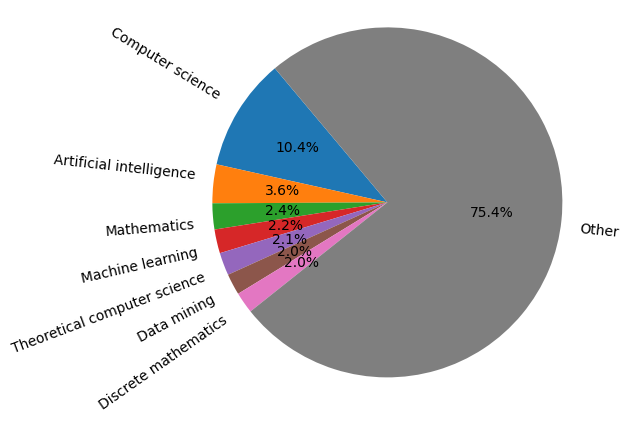

In [91]:
import matplotlib.pyplot as plt
# TODO: make smaller. leave only 4%>. label the rest as "other"
labels = list(topPercentileFreqs.keys())
sizes = list(topPercentileFreqs.values())
plt.figure(figsize=(6,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', rotatelabels=True, startangle=130)
plt.axis("equal")
plt.show()

In [233]:
torch.std(sequences[-1][1].y)

tensor(0.0002)

In [220]:
gat = GATEncoder(num_features, 128, num_heads)
temporal = TemporalModel(128, 128, num_nodes)
pipeline = GraphTemporalPipeline(gat, temporal)
optimizer = torch.optim.Adam(pipeline.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [221]:
train_lstm(50, sequences_harmonic, pipeline, optimizer, criterion)

  2%|▏         | 1/50 [02:01<1:39:04, 121.32s/it]

Loss: 91511.3359


 12%|█▏        | 6/50 [13:20<1:38:57, 134.95s/it]

Loss: 75898.2969


 22%|██▏       | 11/50 [24:35<1:27:49, 135.12s/it]

Loss: 70670.5469


 32%|███▏      | 16/50 [35:53<1:16:45, 135.46s/it]

Loss: 68726.6719


 42%|████▏     | 21/50 [47:11<1:05:32, 135.61s/it]

Loss: 67962.6016


 52%|█████▏    | 26/50 [58:41<55:20, 138.36s/it]  

Loss: 67648.3438


 62%|██████▏   | 31/50 [1:10:03<43:10, 136.35s/it]

Loss: 67513.5234


 72%|███████▏  | 36/50 [1:21:22<31:41, 135.79s/it]

Loss: 67453.1016


 82%|████████▏ | 41/50 [1:32:40<20:21, 135.67s/it]

Loss: 67424.6172


 92%|█████████▏| 46/50 [1:43:58<09:02, 135.67s/it]

Loss: 67410.3594


100%|██████████| 50/50 [1:53:01<00:00, 135.63s/it]

Loss: 67403.8906


In [222]:
graphs_harmonic.append(load_graph(2016, graph, encoded_data_no_year, nx.harmonic_centrality))
sequences_harmonic.append([graphs_harmonic[:-1], graphs_harmonic[-1]])
pipeline.eval()
with torch.no_grad():
    preds = pipeline(sequences_harmonic[-1][0])
    loss = criterion(preds, sequences_harmonic[-1][1].y.unsqueeze(0))
    print(f"Loss on test = {loss.item()}")

Loss on test = 67159.0703125


In [223]:
torch.std(sequences_harmonic[-1][1].y)

tensor(68.2163)